In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import math
from scipy.stats import zscore
from math import log2, log

In [2]:
dataframe = pd.read_csv('preprocessedData.csv', index_col = 'ReadingDateTime', parse_dates = True)
dataframe

,BP,NO,NO2,NOX,SO2,SOLR,WDIR,WSPD
ReadingDateTime,,,,,,,,
2014-01-01 00:00:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:15:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:30:00,997.0,0.1,15.1,15.2,2.4,0.0,192.0,3.5
2014-01-01 00:45:00,997.0,0.1,15.1,15.2,2.4,0.0,209.0,3.5
2014-01-01 01:00:00,997.0,0.1,15.1,15.2,2.4,0.0,203.0,3.2
...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:00:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:15:00,1029.0,0.0,3.9,3.9,2.3,5.0,272.0,0.2


In [3]:
def shiftFiveReadings(dataframe, name):
    data = dataframe.copy()
    newColumn1 = name + "_Previous_1st_Reading"
    data[newColumn1] = dataframe[name].shift(+1)
      
    newColumn2 = name + "_Previous_2nd_Reading"
    data[newColumn2] = dataframe[name].shift(+2)
        
    newColumn3 = name + "_Previous_3rd_Reading"
    data[newColumn3] = dataframe[name].shift(+3)
        
    newColumn4 = name + "_Previous_4th_Reading"
    data[newColumn4] = dataframe[name].shift(+4)
       
    newColumn5 = name + "_Previous_5th_Reading"
    data[newColumn5] = dataframe[name].shift(+5)
    return data

In [4]:
dataframeA = shiftFiveReadings(dataframe, 'NOX')
dataframeA.interpolate(method = 'linear', axis = 0, limit_direction = 'both', inplace = True)
features = dataframeA[dataframeA.columns.difference(['NOX'])]
dataframeA['NOX'] = zscore(dataframeA['NOX'])

In [5]:
bin = [0 for _ in range(dataframeA.shape[0])]

def equalWidthBinning(dataframe):
    for index in range(dataframe.shape[0]):
        value = dataframe['NOX'][index]
        if value >= -3 and value < -2:
            bin[index] = 0
        elif value >= -2 and value < -1 :
            bin[index] = 1
        elif value >= -1 and value < 0:
            bin[index] = 2
        elif value >= 0 and value < 1:
            bin[index] = 3
        elif value >= 1 and value < 2: 
            bin[index] = 4
        elif value >= 2 and value < 3:
            bin[index] = 5
        else:
            pass
    return bin

In [6]:
dataframeA['Bin'] = equalWidthBinning(dataframeA)
dataframeA

,BP,NO,NO2,NOX,SO2,SOLR,WDIR,WSPD,NOX_Previous_1st_Reading,NOX_Previous_2nd_Reading,NOX_Previous_3rd_Reading,NOX_Previous_4th_Reading,NOX_Previous_5th_Reading,Bin
ReadingDateTime,,,,,,,,,,,,,,
2014-01-01 00:00:00,997.0,0.1,15.1,-0.661194,2.4,0.0,187.0,4.9,15.2,15.2,15.2,15.2,15.2,2
2014-01-01 00:15:00,997.0,0.1,15.1,-0.661194,2.4,0.0,187.0,4.9,15.2,15.2,15.2,15.2,15.2,2
2014-01-01 00:30:00,997.0,0.1,15.1,-0.661194,2.4,0.0,192.0,3.5,15.2,15.2,15.2,15.2,15.2,2
2014-01-01 00:45:00,997.0,0.1,15.1,-0.661194,2.4,0.0,209.0,3.5,15.2,15.2,15.2,15.2,15.2,2
2014-01-01 01:00:00,997.0,0.1,15.1,-0.661194,2.4,0.0,203.0,3.2,15.2,15.2,15.2,15.2,15.2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,1029.0,0.0,3.9,-1.285501,2.3,5.0,282.0,0.2,3.9,3.9,3.9,3.9,3.9,1
2018-12-31 23:00:00,1029.0,0.0,3.9,-1.285501,2.3,5.0,282.0,0.2,3.9,3.9,3.9,3.9,3.9,1
2018-12-31 23:15:00,1029.0,0.0,3.9,-1.285501,2.3,5.0,272.0,0.2,3.9,3.9,3.9,3.9,3.9,1


In [7]:
dataframeA['Bin'].value_counts()

2    82355
3    36360
1    20893
4    17558
5    12118
Name: Bin, dtype: int64

In [8]:
def infoGain(features, target, attribute):
    classSet = set()
    classMap = {}
    totalSize = target.size
    data = np.array(features[attribute])
    entropy = 0 
    count = []
    index = 0
    for i in target:
        if(i not in classSet):
            classSet.add(i)
            classMap[i] = index
            count.append(1)
            index += 1
        else:
            count[classMap[i]] += 1
    
    for i in count:
        p = (i / totalSize)
        entropy += p*log2(p)
    
    attributeSet = set() 
    attributeMap = {} 
    attributeCount = []
    attributeIndex = 0
    
    for j in data:
        if(j not in attributeSet):
            attributeSet.add(j)
            attributeMap[j] = attributeIndex
            attributeCount.append(1)
            attributeIndex += 1
        else:
            attributeCount[attributeMap[j]] += 1 
        
    cc_a = [0 for i in range(len(attributeSet) * len(classSet))]
    class_counter_a = np.reshape(cc_a, (len(attributeSet), len(classSet)))
    
    for j in range(data.shape[0]):
        class_counter_a[attributeMap[data[j]]][classMap[target[j]]]+=1

    
    entropy_a=0
    for y in range(len(attributeSet)):
        summation = 0;
        entropy_b = 0
        for z in range(len(classSet)):
            summation += class_counter_a[y][z]
            
        for z in range(len(classSet)):
            p = class_counter_a[y][z] / summation     
            if p!=0:
                entropy_b += p * log2(p)
        entropy_b *= (attributeCount[y]/totalSize)
        entropy_a += entropy_b
    return entropy_a - entropy

In [9]:
informationGain = {}
attributes = ['BP', 'NO', 'NO2', 'SO2', 'SOLR', 'WDIR', 'WSPD', 'NOX_Previous_1st_Reading', 'NOX_Previous_2nd_Reading', 'NOX_Previous_3rd_Reading', 'NOX_Previous_4th_Reading', 'NOX_Previous_5th_Reading']
for attribute in attributes:
    informationGain[attribute] = infoGain(features, dataframeA['Bin'], attribute)
informationGain

{'BP': 0.09458817427911215,
 'NO': 0.8109772061542166,
 'NO2': 1.3909459679846692,
 'SO2': 0.19748138511109126,
 'SOLR': 0.2178437191906999,
 'WDIR': 0.12333884282430096,
 'WSPD': 0.18063416100879048,
 'NOX_Previous_1st_Reading': 1.5595344111005924,
 'NOX_Previous_2nd_Reading': 1.3719356206176543,
 'NOX_Previous_3rd_Reading': 1.2470119099602763,
 'NOX_Previous_4th_Reading': 1.1470905105345253,
 'NOX_Previous_5th_Reading': 1.0673872093820744}

In [10]:
features = dataframeA[dataframeA.columns.difference(['NOX', 'Bin'])]
output = dataframeA['NOX']
training_features, testing_features, training_output, testing_output = train_test_split(features, output, test_size = 0.30)

In [11]:
training_features.columns

Index(['BP', 'NO', 'NO2', 'NOX_Previous_1st_Reading',
       'NOX_Previous_2nd_Reading', 'NOX_Previous_3rd_Reading',
       'NOX_Previous_4th_Reading', 'NOX_Previous_5th_Reading', 'SO2', 'SOLR',
       'WDIR', 'WSPD'],
      dtype='object')

In [12]:
weights = []
for column in training_features.columns:
    weights.append(informationGain[column])
print(weights)

[0.09458817427911215, 0.8109772061542166, 1.3909459679846692, 1.5595344111005924, 1.3719356206176543, 1.2470119099602763, 1.1470905105345253, 1.0673872093820744, 0.19748138511109126, 0.2178437191906999, 0.12333884282430096, 0.18063416100879048]


In [13]:
def weightedDistance(vectorA, vectorB):
    return np.sqrt(np.sum(np.square(np.subtract(np.multiply(weights, vectorA), np.multiply(weights, vectorB)))))

In [14]:
knnRegressor = neighbors.KNeighborsRegressor(n_jobs = -1, n_neighbors = 11, metric = weightedDistance)
knnRegressor.fit(training_features, training_output)

KNeighborsRegressor(metric=<function weightedDistance at 0x00000220F32D6A60>,
                    n_jobs=-1, n_neighbors=11)

In [15]:
start = time.time()

prediction = pd.Series(knnRegressor.predict(testing_features[0 : 500]), index = testing_features.index[0 : 500]).astype('float64')
print("1st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[500 : 1000]), index = testing_features.index[500 : 1000])])
print("2nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1000 : 1500]), index = testing_features.index[1000 : 1500])])
print("3rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1500 : 2000]), index = testing_features.index[1500 : 2000])])
print("4th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2000 : 2500]), index = testing_features.index[2000 : 2500])])
print("5th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2500 : 3000]), index = testing_features.index[2500 : 3000])])
print("6th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3000 : 3500]), index = testing_features.index[3000 : 3500])])
print("7th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3500 : 4000]), index = testing_features.index[3500 : 4000])])
print("8th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4000 : 4500]), index = testing_features.index[4000 : 4500])])
print("9th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4500 : 5000]), index = testing_features.index[4500 : 5000])])
print("10th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5000 : 5500]), index = testing_features.index[5000 : 5500])])
print("11th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5500 : 6000]), index = testing_features.index[5500 : 6000])])
print("12th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6000 : 6500]), index = testing_features.index[6000 : 6500])])
print("13th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6500 : 7000]), index = testing_features.index[6500 : 7000])])
print("14th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7000 : 7500]), index = testing_features.index[7000 : 7500])])
print("15th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7500 : 8000]), index = testing_features.index[7500 : 8000])])
print("16th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8000 : 8500]), index = testing_features.index[8000 : 8500])])
print("17th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8500 : 9000]), index = testing_features.index[8500 : 9000])])
print("18th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9000 : 9500]), index = testing_features.index[9000 : 9500])])
print("19th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9500 : 10000]), index = testing_features.index[9500 : 10000])])
print("20th iteration - ", time.time())

print(prediction)

1st iteration -  1652316456.5763168
2nd iteration -  1652316946.6960118
3rd iteration -  1652317420.0286262
4th iteration -  1652317891.498059
5th iteration -  1652318286.2985682
6th iteration -  1652318651.9386392
7th iteration -  1652319012.7948217
8th iteration -  1652319388.568719
9th iteration -  1652319745.261427
10th iteration -  1652321066.8930411
11th iteration -  1652322406.7700663
12th iteration -  1652323678.2524288
13th iteration -  1652324210.783891
14th iteration -  1652324772.7443452
15th iteration -  1652325172.6094825
16th iteration -  1652325819.2308698
17th iteration -  1652327071.8531723
18th iteration -  1652328330.412785
19th iteration -  1652329466.699012
20th iteration -  1652330027.8061955
ReadingDateTime
2015-11-23 23:45:00   -0.492937
2014-05-26 16:30:00   -0.748298
2015-01-22 13:00:00   -0.655166
2018-01-13 15:15:00   -0.216695
2017-12-19 04:00:00    1.736844
                         ...   
2014-09-17 23:15:00   -0.269432
2017-10-06 16:00:00   -1.339243
201

In [16]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10000 : 10500]), index = testing_features.index[10000 : 10500])])
print("21st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10500 : 11000]), index = testing_features.index[10500 : 11000])])
print("22nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11000 : 11500]), index = testing_features.index[11000 : 11500])])
print("23rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11500 : 12000]), index = testing_features.index[11500 : 12000])])
print("24th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12000 : 12500]), index = testing_features.index[12000 : 12500])])
print("25th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12500 : 13000]), index = testing_features.index[12500 : 13000])])
print("26th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13000 : 13500]), index = testing_features.index[13000 : 13500])])
print("27th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13500 : 14000]), index = testing_features.index[13500 : 14000])])
print("28th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14000 : 14500]), index = testing_features.index[14000 : 14500])])
print("29th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14500 : 15000]), index = testing_features.index[14500 : 15000])])
print("30th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15000 : 15500]), index = testing_features.index[15000 : 15500])])
print("31st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15500 : 16000]), index = testing_features.index[15500 : 16000])])
print("32nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16000 : 16500]), index = testing_features.index[16000 : 16500])])
print("33rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16500 : 17000]), index = testing_features.index[16500 : 17000])])
print("34th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17000 : 17500]), index = testing_features.index[17000 : 17500])])
print("35th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17500 : 18000]), index = testing_features.index[17500 : 18000])])
print("36th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18000 : 18500]), index = testing_features.index[18000 : 18500])])
print("37th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18500 : 19000]), index = testing_features.index[18500 : 19000])])
print("38th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19000 : 19500]), index = testing_features.index[19000 : 19500])])
print("39th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19500 : 20000]), index = testing_features.index[19500 : 20000])])
print("40th iteration - ", time.time())

print(prediction)

21st iteration -  1652330574.5578868
22nd iteration -  1652331094.5916228
23rd iteration -  1652331623.825354
24th iteration -  1652332045.3791857
25th iteration -  1652332505.365179
26th iteration -  1652332928.3762906
27th iteration -  1652333360.7124825
28th iteration -  1652333784.4433906
29th iteration -  1652334203.7793949
30th iteration -  1652334646.7987986
31st iteration -  1652335081.6970916
32nd iteration -  1652335509.2892766
33rd iteration -  1652335937.2632563
34th iteration -  1652336376.6999693
35th iteration -  1652336910.4852347
36th iteration -  1652337427.4355054
37th iteration -  1652337885.3952012
38th iteration -  1652338359.0003781
39th iteration -  1652338811.083889
40th iteration -  1652339298.0376878
ReadingDateTime
2015-11-23 23:45:00   -0.492937
2014-05-26 16:30:00   -0.748298
2015-01-22 13:00:00   -0.655166
2018-01-13 15:15:00   -0.216695
2017-12-19 04:00:00    1.736844
                         ...   
2017-01-14 03:30:00   -0.758129
2018-07-11 21:45:00   -

In [17]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20000 : 20500]), index = testing_features.index[20000 : 20500])])
print("41st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20500 : 21000]), index = testing_features.index[20500 : 21000])])
print("42nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21000 : 21500]), index = testing_features.index[21000 : 21500])])
print("43rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21500 : 22000]), index = testing_features.index[21500 : 22000])])
print("44th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22000 : 22500]), index = testing_features.index[22000 : 22500])])
print("45th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22500 : 23000]), index = testing_features.index[22500 : 23000])])
print("46th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23000 : 23500]), index = testing_features.index[23000 : 23500])])
print("47th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23500 : 24000]), index = testing_features.index[23500 : 24000])])
print("48th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24000 : 24500]), index = testing_features.index[24000 : 24500])])
print("49th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24500 : 25000]), index = testing_features.index[24500 : 25000])])
print("50th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25000 : 25500]), index = testing_features.index[25000 : 25500])])
print("51st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25500 : 26000]), index = testing_features.index[25500 : 26000])])
print("52nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26000 : 26500]), index = testing_features.index[26000 : 26500])])
print("53rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26500 : 27000]), index = testing_features.index[26500 : 27000])])
print("54th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27000 : 27500]), index = testing_features.index[27000 : 27500])])
print("55th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27500 : 28000]), index = testing_features.index[27500 : 28000])])
print("56th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28000 : 28500]), index = testing_features.index[28000 : 28500])])
print("57th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28500 : 29000]), index = testing_features.index[28500 : 29000])])
print("58th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29000 : 29500]), index = testing_features.index[29000 : 29500])])
print("59th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29500 : 30000]), index = testing_features.index[29500 : 30000])])
print("60th iteration - ", time.time())

print(prediction)

41st iteration -  1652339785.251532
42nd iteration -  1652340270.7637928
43rd iteration -  1652340788.574248
44th iteration -  1652341307.5772777
45th iteration -  1652341837.6912518
46th iteration -  1652342361.6875062
47th iteration -  1652342868.526879
48th iteration -  1652343322.688393
49th iteration -  1652343747.168921
50th iteration -  1652344201.1497276
51st iteration -  1652344652.956193
52nd iteration -  1652345098.9471843
53rd iteration -  1652345560.658876
54th iteration -  1652346010.1989422
55th iteration -  1652346454.3573806
56th iteration -  1652346919.5577784
57th iteration -  1652347379.5264733
58th iteration -  1652347826.8522942
59th iteration -  1652348279.8136683
60th iteration -  1652348725.3771217
ReadingDateTime
2015-11-23 23:45:00   -0.492937
2014-05-26 16:30:00   -0.748298
2015-01-22 13:00:00   -0.655166
2018-01-13 15:15:00   -0.216695
2017-12-19 04:00:00    1.736844
                         ...   
2014-11-17 08:15:00    0.914355
2016-10-11 20:00:00    0.43

In [18]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30000 : 30500]), index = testing_features.index[30000 : 30500])])
print("61st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30500 : 31000]), index = testing_features.index[30500 : 31000])])
print("62nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31000 : 31500]), index = testing_features.index[31000 : 31500])])
print("63rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31500 : 32000]), index = testing_features.index[31500 : 32000])])
print("64th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32000 : 32500]), index = testing_features.index[32000 : 32500])])
print("65th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32500 : 33000]), index = testing_features.index[32500 : 33000])])
print("66th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33000 : 33500]), index = testing_features.index[33000 : 33500])])
print("67th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33500 : 34000]), index = testing_features.index[33500 : 34000])])
print("68th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34000 : 34500]), index = testing_features.index[34000 : 34500])])
print("69th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34500 : 35000]), index = testing_features.index[34500 : 35000])])
print("70th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35000 : 35500]), index = testing_features.index[35000 : 35500])])
print("71st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35500 : 36000]), index = testing_features.index[35500 : 36000])])
print("72nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36000 : 36500]), index = testing_features.index[36000 : 36500])])
print("73rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36500 : 37000]), index = testing_features.index[36500 : 37000])])
print("74th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37000 : 37500]), index = testing_features.index[37000 : 37500])])
print("75th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37500 : 38000]), index = testing_features.index[37500 : 38000])])
print("76th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38000 : 38500]), index = testing_features.index[38000 : 38500])])
print("77th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38500 : 39000]), index = testing_features.index[38500 : 39000])])
print("78th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39000 : 39500]), index = testing_features.index[39000 : 39500])])
print("79th iteration - ", time.time())                                                                               

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39500 : 40000]), index = testing_features.index[39500 : 40000])])
print("80th iteration - ", time.time())

print(prediction)

61st iteration -  1652349213.615995
62nd iteration -  1652349703.8267548
63rd iteration -  1652350218.4901774
64th iteration -  1652350730.7161803
65th iteration -  1652351234.6288588
66th iteration -  1652351662.4320936
67th iteration -  1652352037.272439
68th iteration -  1652352410.2551224
69th iteration -  1652352782.518225
70th iteration -  1652353157.460942
71st iteration -  1652353532.929672
72nd iteration -  1652353905.2359169
73rd iteration -  1652354279.7137227
74th iteration -  1652354657.2255452
75th iteration -  1652355035.699589
76th iteration -  1652355414.8721352
77th iteration -  1652355783.3243594
78th iteration -  1652356163.0374687
79th iteration -  1652356531.8444207
80th iteration -  1652356909.588002
ReadingDateTime
2015-11-23 23:45:00   -0.492937
2014-05-26 16:30:00   -0.748298
2015-01-22 13:00:00   -0.655166
2018-01-13 15:15:00   -0.216695
2017-12-19 04:00:00    1.736844
                         ...   
2017-07-24 03:15:00   -0.774704
2018-07-12 08:30:00   -1.27

In [19]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40000 : 40500]), index = testing_features.index[40000 : 40500])])
print("81st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40500 : 41000]), index = testing_features.index[40500 : 41000])])
print("82nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41000 : 41500]), index = testing_features.index[41000 : 41500])])
print("83rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41500 : 42000]), index = testing_features.index[41500 : 42000])])
print("84th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42000 : 42500]), index = testing_features.index[42000 : 42500])])
print("85th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42500 : 43000]), index = testing_features.index[42500 : 43000])])
print("86th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43000 : 43500]), index = testing_features.index[43000 : 43500])])
print("87th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43500 : 44000]), index = testing_features.index[43500 : 44000])])
print("88th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44000 : 44500]), index = testing_features.index[44000 : 44500])])
print("89th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44500 : 45000]), index = testing_features.index[44500 : 45000])])
print("90th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45000 : 45500]), index = testing_features.index[45000 : 45500])])
print("91st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45500 : 46000]), index = testing_features.index[45500 : 46000])])
print("92nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46000 : 46500]), index = testing_features.index[46000 : 46500])])
print("93rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46500 : 47000]), index = testing_features.index[46500 : 47000])])
print("94th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47000 : 47500]), index = testing_features.index[47000 : 47500])])
print("95th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47500 : 48000]), index = testing_features.index[47500 : 48000])])
print("96th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48000 : 48500]), index = testing_features.index[48000 : 48500])])
print("97th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48500 : 49000]), index = testing_features.index[48500 : 49000])])
print("98th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49000 : 49500]), index = testing_features.index[49000 : 49500])])
print("99th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49500 : 50000]), index = testing_features.index[49500 : 50000])])
print("100th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50000 : 50500]), index = testing_features.index[50000 : 50500])])
print("101st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50500 : ]), index = testing_features.index[50500 : ])])
end = time.time()
print("102nd iteration - ", end)

print(prediction)

81st iteration -  1652357280.303593
82nd iteration -  1652357656.7127721
83rd iteration -  1652358031.381916
84th iteration -  1652358405.547745
85th iteration -  1652358770.6126258
86th iteration -  1652359149.6997893
87th iteration -  1652359527.7139537
88th iteration -  1652359897.301385
89th iteration -  1652360261.601804
90th iteration -  1652360639.5609875
91st iteration -  1652361046.682738
92nd iteration -  1652361430.0554538
93rd iteration -  1652361809.7932615
94th iteration -  1652362184.2201679
95th iteration -  1652362557.8027065
96th iteration -  1652362926.7330356
97th iteration -  1652363300.662413
98th iteration -  1652363675.8094823
99th iteration -  1652364054.0574734
100th iteration -  1652364426.518738
101st iteration -  1652364789.7721024
102nd iteration -  1652365009.4018807
ReadingDateTime
2015-11-23 23:45:00   -0.492937
2014-05-26 16:30:00   -0.748298
2015-01-22 13:00:00   -0.655166
2018-01-13 15:15:00   -0.216695
2017-12-19 04:00:00    1.736844
               

In [20]:
mse = mean_squared_error(testing_output, prediction)
print("Mean Square Error = {}".format(mse))
  
r_square = r2_score(testing_output, prediction)
print("R-Square = {}".format(r_square))
    
mae = mean_absolute_error(testing_output, prediction)
print("Mean Absolute Error = {}".format(mae))
    
rmse = math.sqrt(mse)
print("Root Mean Square Error = {}".format(rmse))

Mean Square Error = 0.021071415690549152
R-Square = 0.9787874252753179
Mean Absolute Error = 0.08406136761229956
Root Mean Square Error = 0.14515996586713967


In [21]:
NOX = pd.read_csv("NOX Metrics.csv")
NOX.loc[len(NOX.index)] = [4.22, 'Attribute Weighted KNN Using Information Gain', 'sqrt(sum(sq(wu-wv)))', 'information gain', 'no', start, end, rmse, mae, mse, r_square]
NOX.to_csv("NOX Metrics.csv", index = False)

In [22]:
df = pd.concat({'Actual' : testing_output,
               'Predicted' : prediction}, 
              axis = 1)
df.to_csv('4.2.2(NOX).csv')

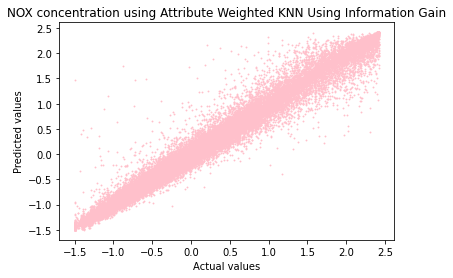

In [23]:
plt.scatter(testing_output, prediction, s = 0.75, c = 'pink')
plt.xlabel('Actual values')
plt.ylabel("Predicted values")
plt.title('NOX concentration using Attribute Weighted KNN Using Information Gain')
plt.show()